In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import ResNet50, MobileNet
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [3]:
main_directory = "/kaggle/input/hybriddataset/raw_dataset_1000"

In [4]:
image_size = (1280, 720)  # Use a smaller image size
batch_size = 4  # Reduced batch size
num_classes = 11  # Number of classes
epochs = 100

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


In [6]:
train_generator = datagen.flow_from_directory(
    main_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 763 images belonging to 11 classes.


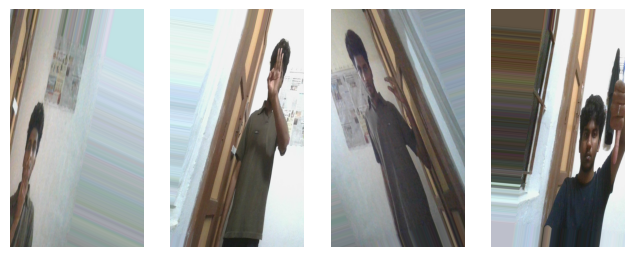

In [ ]:
images, labels = next(train_generator)

# Plot the first 5 images
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i]) 
    plt.axis('off')
plt.show()

In [8]:
val_generator = datagen.flow_from_directory(
    main_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 183 images belonging to 11 classes.


In [ ]:
def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_generator)
val_dataset = create_dataset(val_generator)

In [10]:
def build_hybrid_model(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Load ResNet50 and MobileNet (without the top classification layer)
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the base models
    resnet50.trainable = False
    mobilenet.trainable = False

    # Extract features from both models
    resnet_features = resnet50(inputs)
    mobilenet_features = mobilenet(inputs)

    # Global Average Pooling to reduce spatial dimensions
    resnet_pool = layers.GlobalAveragePooling2D()(resnet_features)
    mobilenet_pool = layers.GlobalAveragePooling2D()(mobilenet_features)

    # Concatenate the features from both models
    concatenated = layers.concatenate([resnet_pool, mobilenet_pool])

    # Add a fully connected layer
    x = layers.Dense(128, activation='relu')(concatenated)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the hybrid model
    model = models.Model(inputs, outputs)
    return model

In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Using TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU/GPU
    print("Using GPU/CPU")

Using GPU/CPU


In [12]:
with strategy.scope():
    input_shape = (image_size[0], image_size[1], 3)  # Input shape for the model
    hybrid_model = build_hybrid_model(input_shape, num_classes)
    early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )
    hybrid_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-10-282cf1c57709>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
hybrid_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1280, 720, 3)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 40, 23, 2048)   │     23,587,712 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenet_1.00_224        │ (None, 40, 22, 1024)   │      3,228,864 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ mobilenet_1.00_224[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3072)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        393,344 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 11)             │          1,419 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,211,339 (103.80 MB)

 Trainable params: 394,763 (1.51 MB)

 Non-trainable params: 26,816,576 (102.30 MB)

In [14]:
history = hybrid_model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_dataset,
    validation_steps=val_generator.samples // batch_size,
    epochs=50,    
    callbacks=[early_stopping] 
)

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.0687 - loss: 3.5080 - val_accuracy: 0.1000 - val_loss: 2.3971
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 176s 933ms/step - accuracy: 0.1083 - loss: 2.3966 - val_accuracy: 0.1006 - val_loss: 2.3943
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 173s 915ms/step - accuracy: 0.1125 - loss: 2.3937 - val_accuracy: 0.1061 - val_loss: 2.3914
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 165s 875ms/step - accuracy: 0.1219 - loss: 2.3921 - val_accuracy: 0.1173 - val_loss: 2.3907
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 154s 816ms/step - accuracy: 0.1052 - loss: 2.3934 - val_accuracy: 0.1117 - val_loss: 2.3899
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 135s 713ms/step - accuracy: 0.1223 - loss: 2.3904 - val_accuracy: 0.1229 - val_loss: 2.3853
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 141s 746ms/step - accuracy: 0.1168 - loss: 2.3846 - val_accuracy: 0.1229 - val_loss: 2.3848
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 144s 762ms/step - accuracy: 0.1154 - lo

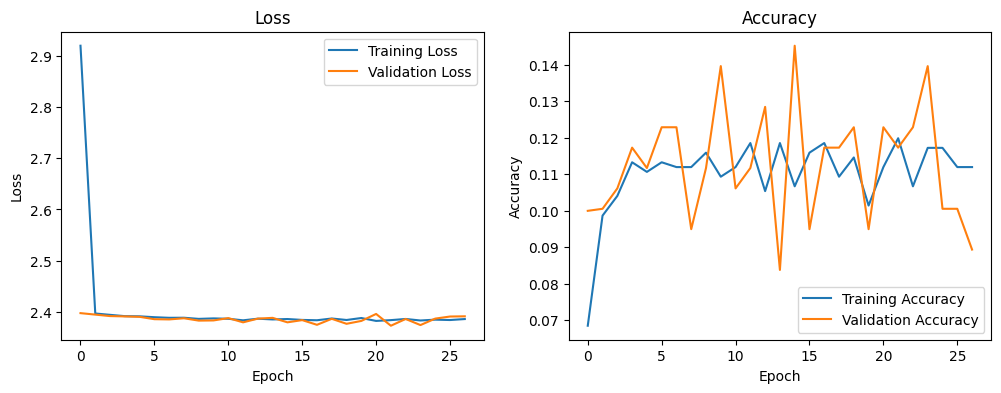

In [15]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_metrics(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


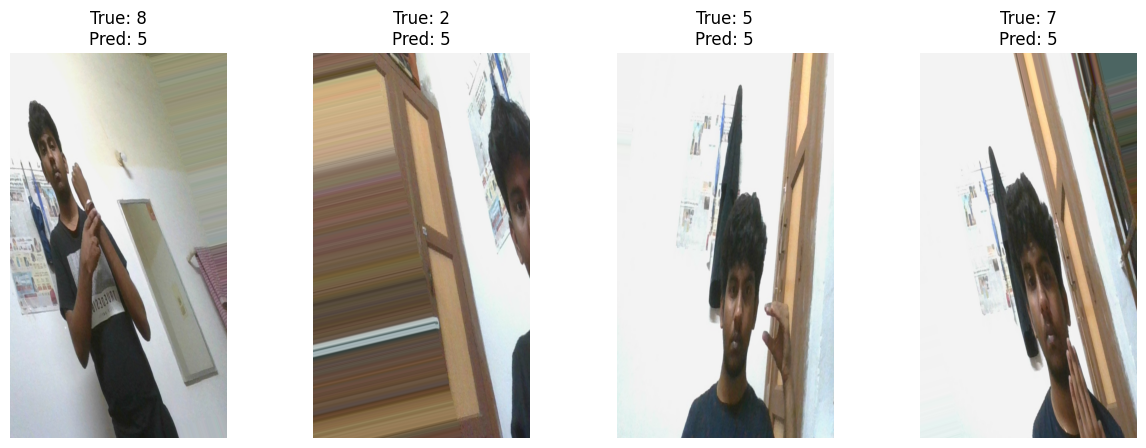

In [16]:
def visualize_predictions(model, generator, num_samples=4):
    x_batch, y_batch = next(generator)  # Get a batch of data
    predictions = model.predict(x_batch)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_batch, axis=1)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_batch[i])  # Display the image
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

visualize_predictions(hybrid_model, val_generator)